### models from https://github.com/qubvel/segmentation_models.pytorch

In [1]:
!wandb login 2a29d4ea12edef115a98307eee0e9bf7db67b635

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import ast
import copy
import gc
import glob
import json
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import skimage
import torch
import wandb
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from torch.optim import lr_scheduler
from tqdm import tqdm

from src.dataset_utils import Dataset, create_transform
from src.train_utils import dice_score, iou_score, seed_everything, train

InteractiveShell.ast_node_interactivity = "all"

In [3]:
wandb.init(dir="/app/_data/", project="tract_segmentation_main")

wandb: Currently logged in as: tatanko. Use `wandb login --relogin` to force relogin


## Train configuration

In [3]:
with open("/app/_data/base_config.json", "r") as f:
    CONFIG = json.load(f)

In [4]:
CONFIG

{'IMG_SIZE': [384, 384],
 'BATCH_SIZE': 18,
 'SEED': 38,
 'ENCODER': 'timm-efficientnet-b4',
 'ENCODER_WEIGHTS': 'noisy-student',
 'MODEL_PATH': '/app/_data/models/model1/',
 'MODEL_NAME': 'DeepLabV3Plus',
 'SEQUENCE': False,
 'N_CHANELS': 1,
 'MODEL_TYPE': 'one_input',
 'NORMALIZE': True,
 'FOLD': 1,
 'UINT8': False,
 'DEVICE': 'cuda',
 'LABELS': {'0': 'large_bowel', '1': 'small_bowel', '2': 'stomach'}}

In [5]:
CONFIG["IMG_SIZE"] = (512, 512)
CONFIG["FOLD"] = 4
CONFIG["SEED"] = 42
CONFIG["NORMALIZE"] = False
CONFIG["BATCH_SIZE"] = 20
CONFIG[
    "MODEL_PATH"
] = f"/app/_data/models/deeplab_fold_{CONFIG['FOLD']}_two_sided_512_seed_{CONFIG['SEED']}_seq_1/"
CONFIG["SEQUENCE"] = True

## Dataframe

In [6]:
df = pd.read_csv("/app/_data/folds.csv")

wrong1 = "case7_day0"
wrong2 = "case81_day30"
df = df[~df["id"].str.contains(wrong1) & ~df["id"].str.contains(wrong2)].reset_index(
    drop=True
)
gkf = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=38)
for n, (train_ixs, val_ix) in enumerate(
    gkf.split(
        X=df,
        y=df["is_mask"],
        groups=df["case"],
    )
):
    df.loc[val_ix, "fold"] = n
for fold in range(6):
    print(f"Proportion of images with mask and without in  fold #{int(fold)}")
    df[df["fold"] != fold][["is_mask"]].sum() / df[df["fold"] == fold][
        ["is_mask"]
    ].sum()

Proportion of images with mask and without in  fold #0


is_mask    4.38459
dtype: float64

Proportion of images with mask and without in  fold #1


is_mask    4.852732
dtype: float64

Proportion of images with mask and without in  fold #2


is_mask    5.653086
dtype: float64

Proportion of images with mask and without in  fold #3


is_mask    5.529295
dtype: float64

Proportion of images with mask and without in  fold #4


is_mask    5.699025
dtype: float64

Proportion of images with mask and without in  fold #5


is_mask    4.244197
dtype: float64

In [7]:
transform_func = create_transform(CONFIG["IMG_SIZE"])

In [8]:
col = "3Dnpy_512_bf"
df[col] = f"/app/_data/{col}/" + df["id"] + ".npy"

In [9]:
train_ds = Dataset(
    df=df[df["fold"] != CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=True,
    seed=CONFIG["SEED"],
    transform=transform_func,
    pad=False,
)
val_ds = Dataset(
    df=df[df["fold"] == CONFIG["FOLD"]],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=False,
    seed=CONFIG["SEED"],
    transform=None,
    pad=False,
)

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=CONFIG["BATCH_SIZE"] * 2, shuffle=False, num_workers=0
)

In [11]:
len(val_loader)

149

In [12]:
# plt.figure(figsize=(20, 20))
# for i in range(0, 16, 2):
#     ix = np.random.randint(0, len(train_ds))
#     img, mask = train_ds[ix]
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(np.moveaxis(img, 0, 2))
#     plt.subplot(4, 4, i + 2)
#     plt.imshow(np.moveaxis(img, 0, 2))
#     plt.imshow(np.moveaxis(mask, 0, 2), alpha=0.3)
# plt.show();

## model

In [15]:
in_channels = 3
decoder_atrous_rates = (12, 24, 36)
decoder_channels = 256
encoder_output_stride = 16
encoder_depth = 5

CONFIG["MODEL_PARAMS"] = {
    "encoder_depth": encoder_depth,
    "decoder_atrous_rates": decoder_atrous_rates,
    "encoder_output_stride": encoder_output_stride,
    "decoder_channels": decoder_channels,
    "in_channels": in_channels,
}
if not os.path.exists(CONFIG["MODEL_PATH"]):
    os.mkdir(CONFIG["MODEL_PATH"])
with open(os.path.join(CONFIG["MODEL_PATH"], "config.json"), "w") as f:
    json.dump(CONFIG, f)

In [16]:
model = smp.DeepLabV3Plus(
    encoder_name=CONFIG["ENCODER"],
    encoder_depth=encoder_depth,
    encoder_weights=CONFIG["ENCODER_WEIGHTS"],
    encoder_output_stride=encoder_output_stride,
    decoder_channels=decoder_channels,
    decoder_atrous_rates=decoder_atrous_rates,
    in_channels=in_channels,
    classes=3,
    activation=None,
    upsampling=4,
    aux_params=None,
)
model = model.to(CONFIG["DEVICE"])

In [17]:
weights = torch.load('/app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth')
model.load_state_dict(weights)

<All keys matched successfully>

In [18]:
JaccardLoss = smp.losses.JaccardLoss(mode="multilabel", from_logits=True)
DiceLoss = smp.losses.DiceLoss(mode="multilabel", from_logits=True)
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode="multilabel", per_image=True)
TverskyLoss = smp.losses.TverskyLoss(
    mode="multilabel", log_loss=False, from_logits=True, alpha=0.7, beta=0.3
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=70, eta_min=1e-6)


def loss_fn(y_pred, y_true):
    return DiceLoss(y_pred, y_true)

In [ ]:
history, best_weights = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    n_epochs=50,
    config=CONFIG,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=loss_fn,
    wandb_log=True,
    early_stopping=5,
)

Train: epoch #1: 100% 1614/1614 [59:56<00:00,  2.23s/it, current_dice=0.7307, epoch_dice=0.6246, gpu_memory=22.57 GB, lr=0.009955, train_loss=0.5907] 
Val:   epoch #1:   0% 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)
Val:   epoch #1: 100% 149/149 [05:00<00:00,  2.02s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.7665, epoch_hd=22.9351, epoch_iou=0.7332, gpu_memory=7.33 GB, val_loss=0.2966]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #2: 100% 1614/1614 [59:47<00:00,  2.22s/it, current_dice=0.7383, epoch_dice=0.7266, gpu_memory=22.89 GB, lr=0.009820, train_loss=0.4419] 
Val:   epoch #2: 100% 149/149 [05:31<00:00,  2.23s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.7523, epoch_hd=24.6901, epoch_iou=0.7220, gpu_memory=7.39 GB, val_loss=0.3308]


Train: epoch #3: 100% 1614/1614 [59:49<00:00,  2.22s/it, current_dice=0.6846, epoch_dice=0.7707, gpu_memory=23.07 GB, lr=0.009598, train_loss=0.3819] 
Val:   epoch #3: 100% 149/149 [05:13<00:00,  2.10s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8460, epoch_hd=16.5724, epoch_iou=0.8125, gpu_memory=7.39 GB, val_loss=0.2057]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #4: 100% 1614/1614 [1:00:19<00:00,  2.24s/it, current_dice=0.7285, epoch_dice=0.8027, gpu_memory=23.07 GB, lr=0.009292, train_loss=0.3429]
Val:   epoch #4: 100% 149/149 [05:24<00:00,  2.18s/it, current_dice=0.8333, current_iou=0.8333, epoch_dice=0.8278, epoch_hd=14.9722, epoch_iou=0.7951, gpu_memory=7.40 GB, val_loss=0.2141]


Train: epoch #5: 100% 1614/1614 [1:00:46<00:00,  2.26s/it, current_dice=0.8713, epoch_dice=0.8234, gpu_memory=23.07 GB, lr=0.008909, train_loss=0.3195]
Val:   epoch #5: 100% 149/149 [05:18<00:00,  2.14s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8592, epoch_hd=22.2669, epoch_iou=0.8260, gpu_memory=7.40 GB, val_loss=0.1984]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #6: 100% 1614/1614 [1:00:30<00:00,  2.25s/it, current_dice=0.8436, epoch_dice=0.8375, gpu_memory=23.07 GB, lr=0.008455, train_loss=0.2955]
Val:   epoch #6: 100% 149/149 [05:17<00:00,  2.13s/it, current_dice=0.9583, current_iou=0.9583, epoch_dice=0.8668, epoch_hd=12.3565, epoch_iou=0.8373, gpu_memory=7.40 GB, val_loss=0.1982]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #7: 100% 1614/1614 [59:46<00:00,  2.22s/it, current_dice=0.8391, epoch_dice=0.8523, gpu_memory=23.07 GB, lr=0.007939, train_loss=0.2788] 
Val:   epoch #7: 100% 149/149 [05:12<00:00,  2.10s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8792, epoch_hd=12.3477, epoch_iou=0.8501, gpu_memory=7.40 GB, val_loss=0.1992]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth




Train: epoch #8: 100% 1614/1614 [59:38<00:00,  2.22s/it, current_dice=0.8619, epoch_dice=0.8588, gpu_memory=22.92 GB, lr=0.007370, train_loss=0.2671] 
Val:   epoch #8: 100% 149/149 [05:17<00:00,  2.13s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8853, epoch_hd=12.7141, epoch_iou=0.8543, gpu_memory=7.40 GB, val_loss=0.1792]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #9: 100% 1614/1614 [59:53<00:00,  2.23s/it, current_dice=0.8485, epoch_dice=0.8648, gpu_memory=23.07 GB, lr=0.006757, train_loss=0.2549] 
Val:   epoch #9: 100% 149/149 [05:12<00:00,  2.10s/it, current_dice=1.0000, current_iou=1.0000, epoch_dice=0.8856, epoch_hd=13.8342, epoch_iou=0.8558, gpu_memory=7.41 GB, val_loss=0.1739]


Valid dice_score improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_dice_weights.pth
Valid loss improved, model saved to /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/weights/best_loss_weights.pth




Train: epoch #10:  88% 1413/1614 [52:16<07:20,  2.19s/it, current_dice=0.9098, epoch_dice=0.8733, gpu_memory=22.92 GB, lr=0.006331, train_loss=0.2433] 

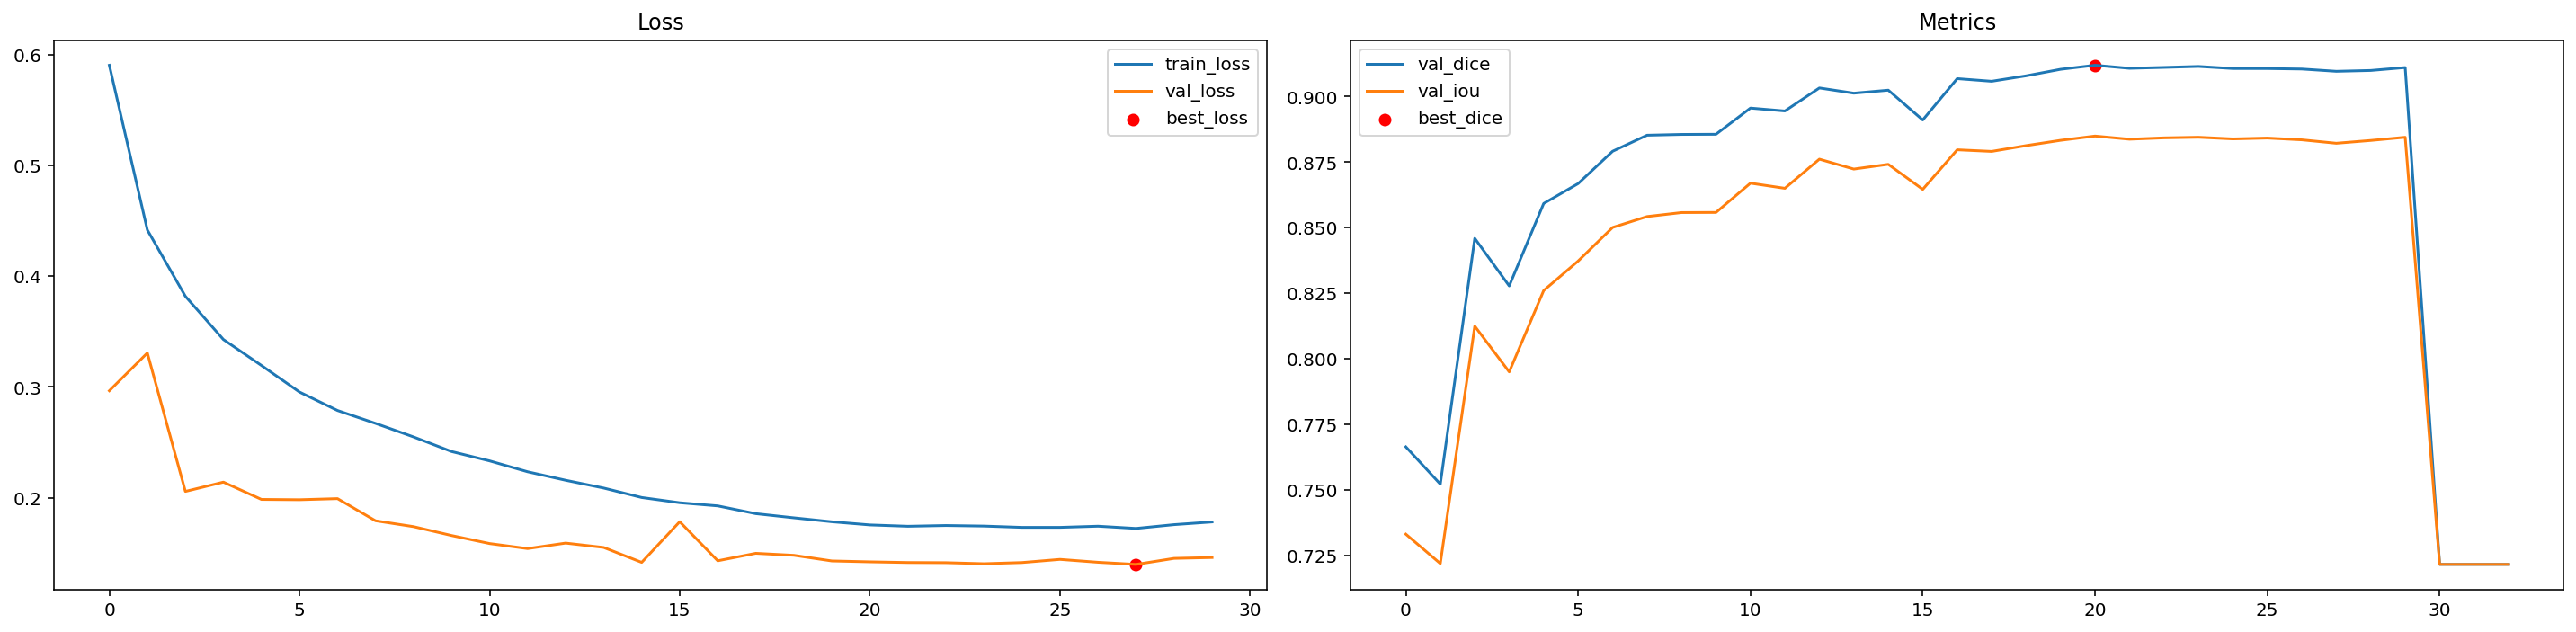

In [18]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(
    history["train_loss"],
    label="train_loss",
)
plt.plot(history["val_loss"], label="val_loss")
plt.scatter(
    history["best_loss_epoch"], history["best_loss"], color="r", label="best_loss"
)
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Metrics")
plt.plot(history["val_dice"], label="val_dice")
plt.plot(history["val_iou"], label="val_iou")
plt.scatter(
    history["best_dice_epoch"], history["best_dice"], color="r", label="best_dice"
)
plt.legend()
plt.tight_layout()
plt.show();

In [21]:
model.load_state_dict(best_weights["loss"])

<All keys matched successfully>

In [22]:
# model.load_state_dict(best_weights["loss"])

In [19]:
test_ds = Dataset(
    df=df[(df["fold"] == CONFIG["FOLD"]) & (df["is_mask"])],
    img_size=CONFIG["IMG_SIZE"],
    n_img_chanels=CONFIG["N_CHANELS"],
    uint8=CONFIG["UINT8"],
    sequence=CONFIG["SEQUENCE"],
    npy_col=col,
    norm=CONFIG["NORMALIZE"],
    shuffle=False,
    seed=CONFIG["SEED"],
    transform=None,
    pad=False,
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=20, shuffle=False, num_workers=0
)

In [20]:
imgs, masks = next(iter(test_loader))

In [21]:
with torch.no_grad():
    predictions = torch.nn.Sigmoid()(model(imgs.to("cuda"))).detach().cpu().numpy()

imgs = imgs.detach().cpu().numpy()
masks = masks.detach().cpu().numpy()

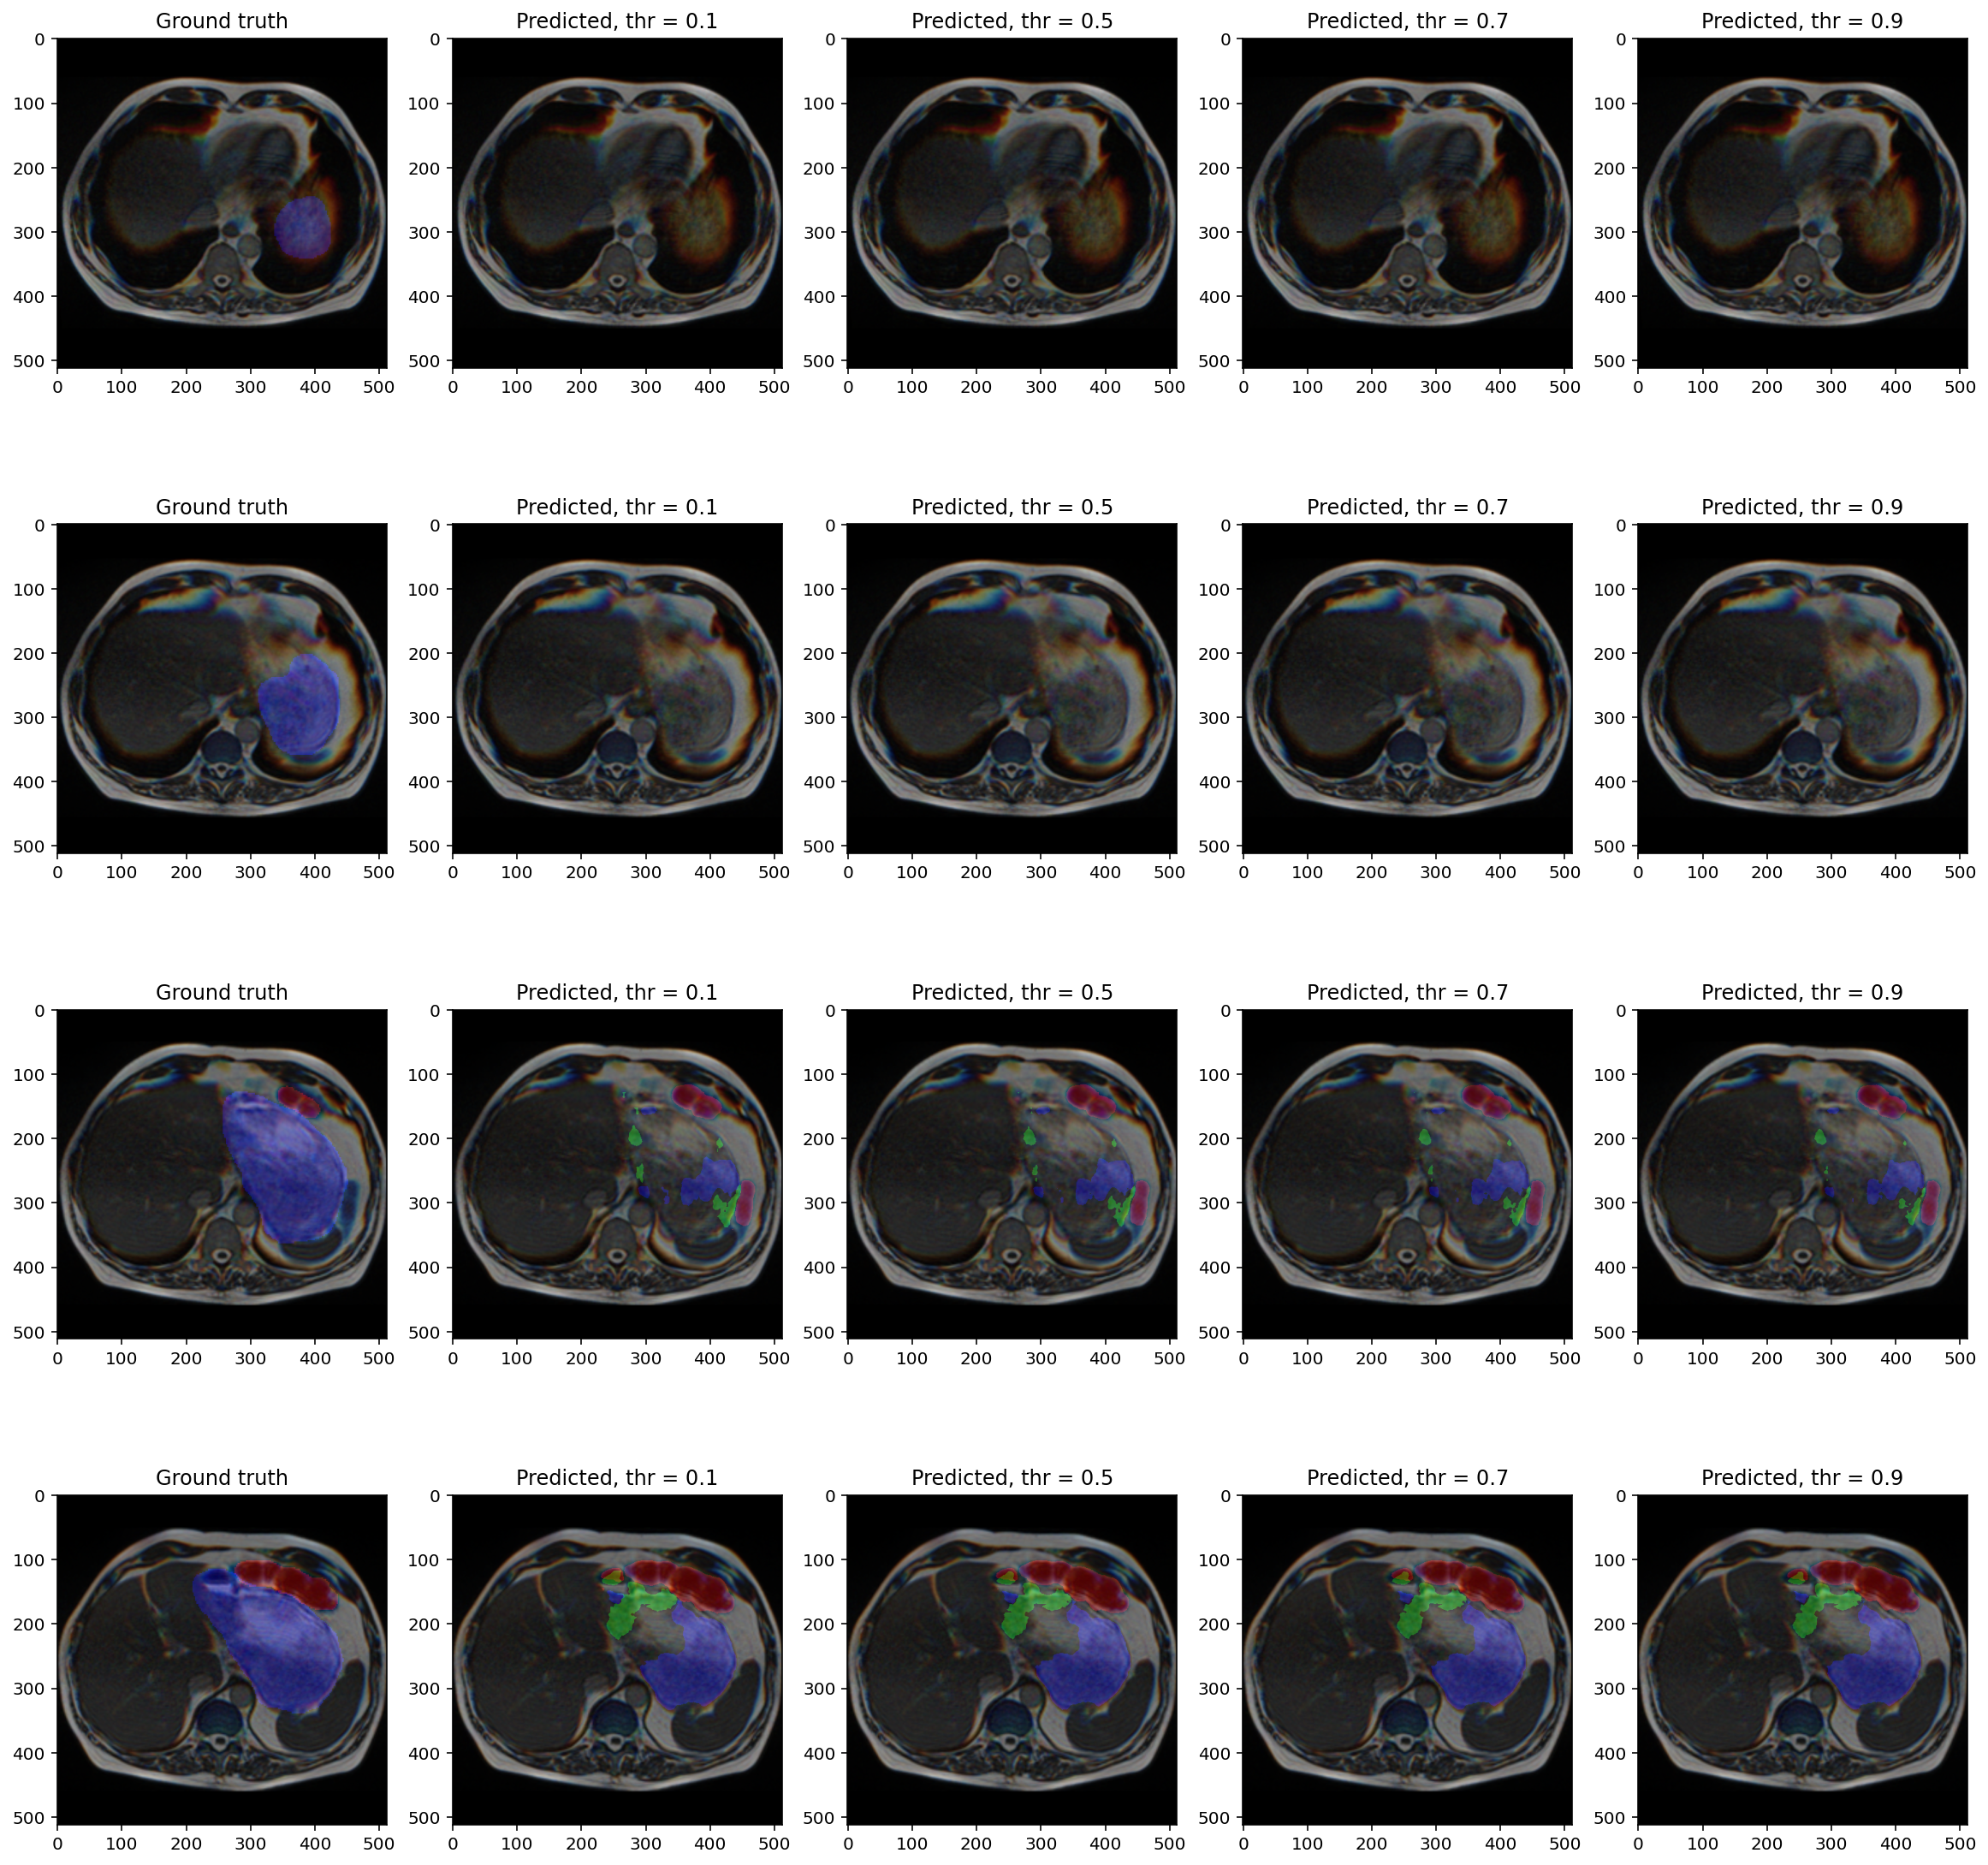

In [22]:
thr = [0.1, 0.5, 0.7, 0.9]

plt.figure(figsize=(20, 20))
for i in range(0, 20, 5):
    pred = predictions[i]
    mask = masks[i]
    img = imgs[i]
    plt.subplot(4, 5, i + 1)
    plt.title("Ground truth")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis(mask.astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 2)
    plt.title(f"Predicted, thr = {thr[0]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[0]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 3)
    plt.title(f"Predicted, thr = {thr[1]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[1]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 4)
    plt.title(f"Predicted, thr = {thr[2]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[2]).astype("float32"), 0, 2), alpha=0.3)
    plt.subplot(4, 5, i + 5)
    plt.title(f"Predicted, thr = {thr[3]}")
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.imshow(np.moveaxis((pred > thr[3]).astype("float32"), 0, 2), alpha=0.3)
plt.show();

In [23]:
CONFIG["MODEL_PATH"]

'/app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/'

In [24]:
!kaggle datasets init -p {CONFIG["MODEL_PATH"]}

Data package template written to: /app/_data/models/deeplab_fold_4_two_sided_512_seed_42_seq_1/dataset-metadata.json


In [25]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "r") as f:
    meta = json.load(f)

In [26]:
name = f"deeplab-fold{CONFIG['FOLD']}-s{CONFIG['SEED']}-512-seq1"
meta["title"] = name
meta["id"] = f"nataliayurasova/{name}"

In [27]:
meta

{'title': 'deeplab-fold4-s42-512-seq1',
 'id': 'nataliayurasova/deeplab-fold4-s42-512-seq1',
 'licenses': [{'name': 'CC0-1.0'}]}

In [28]:
with open(os.path.join(CONFIG["MODEL_PATH"], "dataset-metadata.json"), "w") as f:
    json.dump(meta, f)

In [29]:
!kaggle datasets create -p {CONFIG["MODEL_PATH"]} -r zip

Starting upload for file weights.zip
100%|█████████████████████████████████████████| 137M/137M [03:09<00:00, 759kB/s]
Upload successful: weights.zip (137MB)
Starting upload for file history.json
100%|██████████████████████████████████████| 3.27k/3.27k [00:02<00:00, 1.14kB/s]
Upload successful: history.json (3KB)
Starting upload for file config.json
100%|████████████████████████████████████████████| 577/577 [00:03<00:00, 153B/s]
Upload successful: config.json (577B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/nataliayurasova/deeplab-fold4-s42-512-seq1
